## Resources
[spaCy][https://www.analyticsvidhya.com/blog/2017/04/natural-language-processing-made-easy-using-spacy-%E2%80%8Bin-python/]

In [2]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics import accuracy_score, precision_score, classification_report
from sklearn.base import TransformerMixin 
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import string
punctuations = string.punctuation

from spacy.lang.en import English

In [3]:
from functions import load_data_set
myers_briggs = load_data_set()

In [4]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

parser = English()

#Custom transformer using spaCy 
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}

# Basic utility function to clean the text 
def clean_text(text):     
    return text.strip().lower()

## For loading posts by personality type from database.

In [6]:
# get_posts_by_type = "SELECT posts FROM raw_data WHERE type = 'ENTJ';"

# posts_by_type = pg_fetch_all(connection, get_posts_by_type)

In [6]:
mb_df = pd.DataFrame(myers_briggs, columns=['type', 'posts'])
types = sorted(mb_df['type'].unique())

post_list = [re.split('\|\|\|+', post) for post in mb_df['posts']]
post_df = pd.DataFrame(post_list)
post_df.insert(loc=0, column='type', value=mb_df['type'])

posts_by_type = {typ: mb_df[mb_df['type'] == typ] for typ in types}

In [23]:
# Convert post_df to a two-column data set.
def compress_posts(df):
    result = []
    df_length = range(len(df))

    for i in df_length:
        for j in range(1, 59):
            if df.iloc[i][j] != None:
                result.append([df['type'][i], df.iloc[i][j]])
    
    return pd.DataFrame(result)

vertical_post_df = compress_posts(post_df)
vertical_post_df.columns = ['type', 'posts']

In [24]:
from collections import Counter

personality_count = Counter()

for i in mb_df['type']:
    personality_count[i] += 1

personality_types = sorted(personality_count)
post_count = [personality_count[x] for x in personality_types]

Text(0, 0.5, 'Number of Posts')

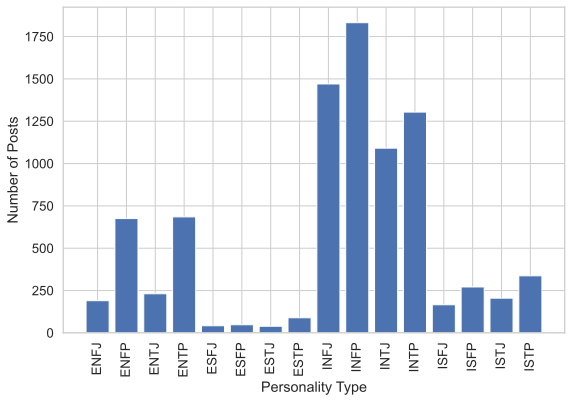

In [25]:
plt.bar(personality_types, post_count)
plt.xticks(rotation=90)
plt.xlabel('Personality Type')
plt.ylabel('Number of Posts')

In [26]:
#Create spacy tokenizer that parses a sentence and generates tokens
#these can also be replaced by word vectors 
def spacy_tokenizer(sentence):
    tokens = parser(sentence)
    tokens = [tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_ for tok in tokens]
    tokens = [tok for tok in tokens if (tok not in stopwords and tok not in punctuations)]

    return tokens

#create vectorizer object to generate feature vectors, we will use custom spacy’s tokenizer
vectorizer = CountVectorizer(tokenizer=spacy_tokenizer, ngram_range=(1,1))
classifier = LinearSVC()

In [27]:
# reformat data into [(text, type)]

In [28]:
# X_train, X_test, y_train, y_test = train_test_split(mb_df['posts'], mb_df['type'])
X_train, X_test, y_train, y_test = train_test_split(vertical_post_df['posts'], vertical_post_df['type'])


train = []
test = []
for i in range(len(X_train)):
    train.append((X_train.iloc[i], y_train.iloc[i]))

for i in range(len(X_test)):
    test.append((X_test.iloc[i], y_test.iloc[i]))

In [29]:
import time
start_time = time.time()

# Create the  pipeline to clean, tokenize, vectorize, and classify 
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', vectorizer),
                 ('classifier', classifier)])

# Create model and measure accuracy
pipe.fit([x[0] for x in train], [x[1] for x in train]) 
pred_data = pipe.predict([x[0] for x in test]) 
# for (sample, pred) in zip(test, pred_data):
#     print(sample, pred)
print("Accuracy:", accuracy_score([x[1] for x in test], pred_data))
print("--- %s seconds ---" % (time.time() - start_time))


Accuracy: 0.25391445807632346


In [30]:
feature_names = vectorizer.get_feature_names()

In [31]:
print("Precision:", precision_score([x[1] for x in test], pred_data, average='micro'))

Precision: 0.25391445807632346


In [32]:
print("Precision:", precision_score([x[1] for x in test], pred_data, average=None))

Precision: [0.14880425 0.22630085 0.13742072 0.21106367 0.07084469 0.07857143
 0.11186441 0.11245675 0.27583305 0.28255876 0.23916172 0.25920813
 0.16731518 0.17033312 0.16741742 0.18946436]


In [33]:
cr = classification_report([x[1] for x in test], pred_data)

In [34]:
cr.split('\n')

['              precision    recall  f1-score   support',
 '',
 '        ENFJ       0.15      0.08      0.10      2198',
 '        ENFP       0.23      0.15      0.18      8053',
 '        ENTJ       0.14      0.07      0.09      2756',
 '        ENTP       0.21      0.14      0.17      8236',
 '        ESFJ       0.07      0.05      0.06       501',
 '        ESFP       0.08      0.04      0.05       570',
 '        ESTJ       0.11      0.07      0.08       484',
 '        ESTP       0.11      0.06      0.08      1072',
 '        INFJ       0.28      0.28      0.28     17646',
 '        INFP       0.28      0.48      0.36     21867',
 '        INTJ       0.24      0.21      0.22     12694',
 '        INTP       0.26      0.27      0.26     15540',
 '        ISFJ       0.17      0.08      0.11      2033',
 '        ISFP       0.17      0.09      0.11      3182',
 '        ISTJ       0.17      0.09      0.12      2399',
 '        ISTP       0.19      0.11      0.14      4040',
 '',
 '  